## COVID-19 FORECAST USING KUBEFLOW FAIRING ON UCS

## Clone Cisco Kubeflow starter pack repository

In [1]:
BRANCH_NAME="dev" #Provide git branch "master" or "dev"
! git clone -b $BRANCH_NAME https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

Cloning into 'cisco-kubeflow-starter-pack'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (522/522), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 2577 (delta 198), reused 403 (delta 113), pack-reused 2055
Receiving objects: 100% (2577/2577), 7.63 MiB | 32.55 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.


## Configure Docker Credentials

Get your docker registry user name and password encoded in base64 

echo -n USERNAME:PASSWORD | base64 

Create a config.json file with your Docker registry url and the previous generated base64 string 

In [ ]:
!echo -n USERNAME:PASSWORD | base64

In [ ]:
%%writefile config.json
{
    "auths": {
        "https://index.docker.io/v1/": {
            "auth": "<<Provide previous generated base64 string>>"
        }
    }
}

## Create Requirements.txt

In [2]:
%%writefile requirements.txt
pandas
keras
seldon-core
tornado>=6.0.3
kubeflow-fairing
tensorflow==1.13.1
cloudpickle==1.1.1
kubernetes==10.0.1
matplotlib
plotly_express

Writing requirements.txt


## Install Requirements

In [3]:
!pip install --user -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Restart Notebook Kernel

In [4]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Import Libraries

In [35]:
import pandas as pd
import numpy as np
import datetime
import re,os
import logging
import sys
import importlib
import time
import tensorflow as tf
import keras
from keras.models import Model
from keras import layers
from keras import Input
from keras import optimizers

from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

## Set up Kubeflow Fairing for training and predictions on On-premise
Import the fairing library and configure the onprem environment that your training or prediction job will run in.

In [2]:
from kubernetes import client as k8s_client
from kubernetes.client import rest as k8s_rest
from kubernetes import config as k8s_config
from kubernetes.client.rest import ApiException

from kubeflow import fairing   
from kubeflow.fairing import utils as fairing_utils
from kubeflow.fairing import TrainJob
from kubeflow.fairing.preprocessors.function import FunctionPreProcessor
from kubeflow.fairing.preprocessors import base as base_preprocessor
from kubeflow.fairing.builders.cluster.cluster import ClusterBuilder

from kubeflow.fairing.cloud.k8s import MinioUploader
from kubeflow.fairing.builders.cluster.minio_context import MinioContextSource
from kubeflow.fairing import PredictionEndpoint
from kubeflow.fairing.kubernetes.utils import mounting_pvc
from kubeflow.fairing.kubernetes.utils import mounting_pvc

BackendClass = getattr(importlib.import_module('kubeflow.fairing.backends'), "KubernetesBackend")
namespace = fairing_utils.get_current_k8s_namespace()
print("Namespace : %s"%namespace)

Namespace : anonymous


## Get minio-service cluster IP to upload docker build context
#### Set DOCKER_REGISTRY
The DOCKER_REGISTRY variable is used to push the newly built image. 
Please change the variable to the registry for which you've configured credentials.

In [3]:
DOCKER_REGISTRY = "poornimadevii"

k8s_config.load_incluster_config()
api_client = k8s_client.CoreV1Api()
custom_api=k8s_client.CustomObjectsApi()
minio_service_endpoint = None

try:
    minio_service_endpoint = api_client.read_namespaced_service(name='minio-service', namespace='kubeflow').spec.cluster_ip
except ApiException as e:
    if e.status == 403:
        logging.warning(f"The service account doesn't have sufficient privileges "
                      f"to get the kubeflow minio-service. "
                      f"You will have to manually enter the minio cluster-ip. "
                      f"To make this function work ask someone with cluster "
                      f"priveleges to create an appropriate "
                      f"clusterrolebinding by running a command.\n"
                      f"kubectl create --namespace=kubeflow rolebinding "
                       "--clusterrole=kubeflow-view "
                       "--serviceaccount=${NAMESPACE}:default-editor "
                       "${NAMESPACE}-minio-view")
        logging.error("API access denied with reason: {e.reason}")

s3_endpoint = minio_service_endpoint
minio_endpoint = "http://"+s3_endpoint+":9000"
minio_username = "minio"
minio_key = "minio123"
minio_region = "us-east-1"
print(minio_endpoint)


minio_uploader = MinioUploader(endpoint_url=minio_endpoint, minio_secret=minio_username, minio_secret_key=minio_key, region_name=minio_region)
minio_context_source = MinioContextSource(endpoint_url=minio_endpoint, minio_secret=minio_username, minio_secret_key=minio_key, region_name=minio_region)

http://10.98.188.38:9000


### Create a config-map in the namespace you're using with the docker config

In [8]:
!kubectl create --namespace $namespace configmap docker-config --from-file=./config.json

configmap/docker-config created


## Define required paths to train & test data files

In [15]:
main_path = 'cisco-kubeflow-starter-pack/apps/healthcare/covid-forecasting/onprem/'
train_data_path = main_path + 'data/train.csv'
test_data_path = main_path + 'data/test.csv'

## Preprocess dataset

#### Define function for preprocessing train data

In [10]:
def preprocess_train(train_df, n_prev, n_next):
    df = train_df.copy()
    input_feats, output_feats = [], []
    
    # Performing Shifting of Previous cases in the positive direction (downwards) for New cases & New Fatalities
    for i in range(1, n_prev+1):
        for feat in ["NewCases", "NewFatalities"]:
            df["{}_prev_{}".format(feat, i)] = df.groupby(["Country_Region", "Province_State"])[feat].shift(i)
            input_feats.append("{}_prev_{}".format(feat, i))
    
    # Performing Shifting of Next Cases in the negative direction (upwards) for New cases & New Fatalities
    output_feats.extend(["NewCases", "NewFatalities"])
    for i in range(1, n_next):
        for feat in ["NewCases", "NewFatalities"]:
            df["{}_next_{}".format(feat, i)] = df.groupby(["Country_Region", "Province_State"])[feat].shift(-i)
            output_feats.append("{}_next_{}".format(feat, i))
    df.dropna(inplace=True)     
    
    #Converting the Province state & Country Region to Dummy/Indicator Variables ( which is a constant)
    const_df = pd.get_dummies(df[["Province_State", "Country_Region"]], drop_first=True)
    
    # Assigning already available data for previous no of days counting back from starting date of forecasting dates
    time_df = df[input_feats]
    time_df = time_df.values.reshape((df.shape[0],-1,2))
    
    #Assigning values to the future no of days counting forth from the starting date of forecasting dates
    output_df = df[output_feats]
    return const_df, time_df, output_df

#### Define function for preprocessing test data

In [12]:
def preprocess_test(train_df, test_df, n_prev):
    input_feats = []
    
    #Appending the training data with test data records with date of specified no of forecasting dates
    append_df = pd.concat([train_df, test_df[test_df["Date"] == train_df["Date"].max() + timedelta(days=1)]])
    
    #Sorting the Dataframe in ascending order of Country region, province state & Date
    append_df.sort_values(["Country_Region", "Province_State", "Date"], ascending=[True, True, True], inplace=True)
    
    # Performing Shifting of Previous cases in the positive direction (downwards) for New cases & New Fatalities
    for i in range(1, n_prev+1):
        for feat in ["NewCases", "NewFatalities"]:
            append_df["{}_prev_{}".format(feat, i)] = append_df.groupby(["Country_Region", "Province_State"])[feat].shift(i)
            input_feats.append("{}_prev_{}".format(feat, i))
            
    # Adding a column of ForecastId if records are not having null values        
    append_df = append_df[append_df["ForecastId"].notnull()]
    
    #Converting the Province state & Country Region to Dummy/Indicator Variables ( which is a constant)
    const_df = pd.get_dummies(append_df[["Province_State", "Country_Region"]], drop_first=True)
    
    # Assigning already available data for previous no of days counting back from starting date of forecasting dates
    time_df = append_df[input_feats]
    time_df = time_df.values.reshape((append_df.shape[0],-1,2))
    
    return const_df, time_df


#### Define main preprocessing function

In [16]:
def covid_preprocess_function():
        
        # Read train and test datasets
        train_df = pd.read_csv(train_data_path)
        print("train_df shape: {0}" .format(train_df.shape))
        test_df = pd.read_csv(test_data_path)
        print("train_df shape: {0}" .format(test_df.shape))

        # Check the NaN value status in each column of the Train data
        # Checking whether no column except Province_State are having NaN values
        train_df.apply(lambda col: col.isnull().value_counts(), axis=0)
        test_df.apply(lambda col: col.isna().value_counts(), axis=0)

        # Replace the values of NaN with ""
        train_df["Province_State"] = train_df["Province_State"].fillna("")
        test_df["Province_State"] = test_df["Province_State"].fillna("")

        # Convert the Date column values to Pandas Datetime format
        train_df["Date"] = pd.to_datetime(train_df["Date"])
        test_df["Date"] = pd.to_datetime(test_df["Date"])

        # Add New Columns for "NewCases" and Fill the Column with difference values from the previous rows
        train_df["NewCases"] = train_df.groupby(["Country_Region", "Province_State"])["ConfirmedCases"].diff(periods=1)

        # Replace "NewCases" NaN values with 0
        train_df["NewCases"] = train_df["NewCases"].fillna(0)

        # Ensure that the NewCases are not negative. If NewCases are negative then they are replaced with zero else the actual value is provided
        train_df["NewCases"] = np.where(train_df["NewCases"] < 0, 0, train_df["NewCases"])

        # Add a column for "NewFatalities" same as for "NewCases"
        train_df["NewFatalities"] = train_df.groupby(["Country_Region", "Province_State"])["Fatalities"].diff(periods=1)
        train_df["NewFatalities"] = train_df["NewFatalities"].fillna(0)
        train_df["NewFatalities"] = np.where(train_df["NewFatalities"] < 0, 0, train_df["NewFatalities"])

        # Apply Natural Logarithmic Function to NewCases and NewFatalities Column
        train_df["NewCases"] = np.log(train_df["NewCases"] + 1)
        train_df["NewFatalities"] = np.log(train_df["NewFatalities"] + 1)
        # print("train_df \n", train_df.head())
        # print("test_df \n", test_df.head())
        
        #Calculate the number of days for which forecasting of New Cases & New Fatalities needs to be performed
        n_next = (test_df["Date"].max() - train_df["Date"].max()).days
        #print("No of Future Days requested to forecast COVID-19 New Cases & New Fatalities:", n_next)
        
        const_df, time_df, output_df = preprocess_train(train_df, n_next, n_next)
        
        const_test_df, time_test_df = preprocess_test(train_df, test_df, n_next)
        
        return (train_df, test_df, const_df, time_df, output_df, const_test_df, time_test_df)
        
        
train_df, test_df, const_df, time_df, output_df, const_test_df, time_test_df = covid_preprocess_function()        

train_df shape: (28170, 6)
train_df shape: (13459, 4)


#### Define function for creating & training model

In [17]:
def covid_model_train_function(model_export_path, epochs, batch_size):
    
    time_input = Input(shape=(time_df.shape[1], time_df.shape[2]))
    lstm = layers.LSTM(64)(time_input)

    const_input = Input(shape=(const_df.shape[1],))

    combine = layers.concatenate([lstm, const_input], axis=-1)
    #lstm_out = layers.Dropout(0.1)(combine)
    output = layers.Dense(output_df.shape[1], activation='softmax')(combine)

    model = Model([time_input, const_input], output)
    #optimizer=optimizers.SGD(lr=0.01, nesterov=True)
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])
    model.summary()
    
    model.fit([time_df, const_df], output_df, epochs=epochs, batch_size=batch_size)
    
    
    input_names = ['input1','input2']
    name_to_input = {name: t_input for name, t_input in zip(input_names, model.inputs)}
    

    tf.saved_model.simple_save(
        keras.backend.get_session(),
        os.path.join(model_export_path, "001"),
        inputs=name_to_input,
        outputs={t.name: t for t in model.outputs})    
    

## Define COVID class to be used for Kubeflow Fairing

In [19]:
class CovidServe(object):
    
    def __init__(self):
            self.model = None
            self.model_export_path = 'covid-model'
            self.epochs = 5
            self.batch_size = 64
                 

    def train(self):
         covid_model_train_function(self.model_export_path, self.epochs, self.batch_size)
         
    def predict(self,X,feature_names=None):
         
        path=os.path.join(os.getcwd(), '/opt/covid-model')
        for dir in os.listdir(path):
            if re.match('[0-9]',dir):
                exported_path=os.path.join(path,dir)
                break
                
        global output_dict
        import logging
        # Open a Session to predict
        with tf.Session() as sess:
            tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], exported_path)
            predictor= tf.contrib.predictor.from_saved_model(exported_path,signature_def_key='serving_default')
            input_data1=[]
            input_data2=[]
            for i in range(len(X[0])):
                input_data1.append(X[0][i])
                input_data2.append(X[1][i])
            output_dict= predictor({"input1": input_data1, "input2": input_data2})
            
        sess.close()
        return output_dict["dense_1/Softmax:0"]


## Train COVID model on Kubeflow using Kubeflow Fairing
Kubeflow Fairing packages the CovidServe class, the training data, and the training job's software prerequisites as a Docker image. Then Kubeflow Fairing deploys and runs the training job on kubeflow.

In [20]:
train_job = TrainJob(CovidServe, input_files=[train_data_path, test_data_path,"requirements.txt"],
                     pod_spec_mutators = [mounting_pvc(pvc_name="nfs1", pvc_mount_path="/app")],
                     docker_registry=DOCKER_REGISTRY, backend=BackendClass(build_context_source=minio_context_source))
train_job.submit()

[W 200508 06:05:13 tasks:54] Using default base docker image: registry.hub.docker.com/library/python:3.6.9
[W 200508 06:05:13 tasks:62] Using builder: <class 'kubeflow.fairing.builders.cluster.cluster.ClusterBuilder'>
[I 200508 06:05:13 tasks:66] Building the docker image.
[I 200508 06:05:13 cluster:46] Building image using cluster builder.
[W 200508 06:05:13 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[I 200508 06:05:13 base:107] Creating docker context: /tmp/fairing_context_8r13kjzy
[W 200508 06:05:13 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[W 200508 06:05:14 manager:296] Waiting for fairing-builder-pgztn-95zbq to start...
[W 200508 06:05:14 manager:296] Waiting for fairing-builder-pgztn-95zbq to start...
[W 200508 06:05:14 manager:296] Waiting for fairing-builder-pgztn-95zbq to start...
[W 200508 06:05:1

INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0002] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0002] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0003] Built cross stage deps: map[]
INFO[0003] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0003] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0003] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0004] Unpacking rootfs as cm

  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427967 sha256=81e4eb0bddd9fb2719bedc52dcf7e149fd27d4148d1b227377211d49ea84533a
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1g19216/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=480459 sha256=8abf6e980dda1fc3feab5daa0f2a070e039a8073bdbd27bb52619c832bf95484
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1g19216/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for jaeger-client: filename=jaeger_client-4.1.0-cp36-none-any.whl size=64309 sha256=18d5d0d58b93824dad302e5d62b0faff89bf989c1215fc5e29ef4ddbb8b150e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1g19216/wheels/f2/84/7f/e89da3ee8ce35598d6382b6389fa2ada5d66acca2422537994
  Created wheel for Flask-OpenTracing: filename=Flask_OpenTracing-1.1.0-cp36-none-any.whl size=9071 sha256=c2b0feb483893dd98355bbf2

  Created wheel for absl-py: filename=absl_py-0.9.0-cp36-none-any.whl size=121931 sha256=5346943a77347300e62c5033272af61e9c508c01354e29bd973bc1b474659e49
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1g19216/wheels/8e/28/49/fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4832 sha256=d5c958d5784e89092cc7e3b5e6b6836005372301f2d9a3bdfbb56c0814efdfd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1g19216/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for threadloop: filename=threadloop-1.0.2-cp36-none-any.whl size=3425 sha256=befbd12935b12e5483532492e260bec6367d02ee03e40ef15b715cd20c6ab8ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1g19216/wheels/d7/7a/30/d212623a4cd34f6cce400f8122b1b7af740d3440c68023d51f
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=483937 sha256=fd76a425e66220757ffc92c907d97a46e718cd220f8a31bee04c89f4

You should consider upgrading via the 'pip install --upgrade pip' command.
INFO[0100] Taking snapshot of full filesystem...
INFO[0108] Adding whiteout for /app
INFO[0159] Using files from context: [/kaniko/buildcontext/app]
INFO[0159] COPY /app/ /app/
INFO[0159] Taking snapshot of files...


[W 200508 06:09:01 job:101] The job fairing-job-7jk2m launched.
[W 200508 06:09:01 manager:296] Waiting for fairing-job-7jk2m-5xjw4 to start...
[W 200508 06:09:01 manager:296] Waiting for fairing-job-7jk2m-5xjw4 to start...
[W 200508 06:09:01 manager:296] Waiting for fairing-job-7jk2m-5xjw4 to start...
[W 200508 06:09:03 manager:296] Waiting for fairing-job-7jk2m-5xjw4 to start...
[I 200508 06:09:54 manager:302] Pod started running True


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

13459/13459 [==============================] - 7s 488us/step - loss: 3.9031 - acc: 0.1289
Epoch 2/5

 5184/13459 [==========>...................] - ETA: 3s - loss: 3.8987 - acc: 0.1464


13459/13459 [==============================] - 6s 467us/step - loss: 3.8961 - acc: 0.1522
Epoch 3/5

 4288/13459 [========>.....................] - ETA: 4s - loss: 3.7928 - acc: 0.1472


13459/13459 [==============================] - 6s 467us/step - loss: 3.8960 - acc: 0.1546
Epoch 4/5

 3392/13459 [======>.......................] - ETA: 4s - loss: 3.9200 - acc: 0.1442


13459/13459 [==============================] - 6s 477us/step - loss: 3.8959 - acc: 0.1504
Epoch 5/5

 2624/13459 [====>.........................] - ETA: 5s - loss: 4.0944 - acc: 0.1555


13459/13459 [==============================] - 6s 461us/step - loss: 3.8958 - acc: 0.1537
From <ipython-input-17-ee53b0bd8ba5>:28: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
From /usr/local/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:205: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
Assets added to graph.
No assets to write.
SavedModel written to: covid-model/001/saved_model.pb


[W 200508 06:10:30 job:173] Cleaning up job fairing-job-7jk2m...


'fairing-job-7jk2m'

## Deploy trained model to Kubeflow for predictions using Kubeflow Fairing
Kubeflow Fairing packages the CovidServe class, the trained model, and the prediction endpoint's software prerequisites as a Docker image. Then Kubeflow Fairing deploys and runs the prediction endpoint on Kubeflow.

In [21]:
endpoint = PredictionEndpoint(CovidServe, input_files=[train_data_path, test_data_path,"requirements.txt"],
                              docker_registry=DOCKER_REGISTRY,
                              pod_spec_mutators = [mounting_pvc(pvc_name="nfs1", pvc_mount_path="/opt")],
                              backend=BackendClass(build_context_source=minio_context_source))
endpoint.create()

[W 200508 06:12:38 tasks:54] Using default base docker image: registry.hub.docker.com/library/python:3.6.9
[W 200508 06:12:38 tasks:62] Using builder: <class 'kubeflow.fairing.builders.cluster.cluster.ClusterBuilder'>
[I 200508 06:12:38 tasks:66] Building the docker image.
[I 200508 06:12:38 cluster:46] Building image using cluster builder.
[W 200508 06:12:38 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[I 200508 06:12:38 base:107] Creating docker context: /tmp/fairing_context_tvt2449q
[W 200508 06:12:38 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[W 200508 06:12:39 manager:296] Waiting for fairing-builder-xxblb-j7k9n to start...
[W 200508 06:12:39 manager:296] Waiting for fairing-builder-xxblb-j7k9n to start...
[W 200508 06:12:39 manager:296] Waiting for fairing-builder-xxblb-j7k9n to start...
[W 200508 06:12:4

INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0002] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0002] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0003] Built cross stage deps: map[]
INFO[0003] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0004] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0004] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0004] Unpacking rootfs as cm

  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427961 sha256=13ff32102254412801bcc96761ba9f18ed2ebc73733e55da4805aeb75ff44781
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v6v9qej/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=480482 sha256=fc42092230d7f6731bc83dfff459ef849e75e7c6dd4668726a411d340b76f280
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v6v9qej/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp36-none-any.whl size=41402 sha256=b17ff7492a939e939d4cdfd6683efca66887ad37429fc6e95b177af7f6a9a053
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v6v9qej/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea
  Created wheel for Flask-OpenTracing: filename=Flask_OpenTracing-1.1.0-cp36-none-any.whl size=9071 sha256=c74787d2a3bf5a0c

  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.6.2-py2.py3-none-any.whl size=72497 sha256=2602fb301898278c5850d51c2db1e7ca54cfd5a1391f8638968732f69cdf4f7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v6v9qej/wheels/8c/4b/43/e3606c88bd7f0169a587d82ad79f5f826f91983106eec3e22b
  Created wheel for absl-py: filename=absl_py-0.9.0-cp36-none-any.whl size=121931 sha256=cc379557146a1d8c263a2e62867a59b547e1df31c9a32b1aa32300bc9cd0e9d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v6v9qej/wheels/8e/28/49/fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4832 sha256=fd3f7ce48cf095c23bf7e5815c96cd52f2520f367cdd3e5f8033671befba0474
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v6v9qej/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for threadloop: filename=threadloop-1.0.2-cp36-none-any.whl size=3425 sha256=9e07a5b6b66656272b9039ee3e8fac12520bbff6cfba562999bfda7

You should consider upgrading via the 'pip install --upgrade pip' command.
INFO[0103] Taking snapshot of full filesystem...
INFO[0163] Using files from context: [/kaniko/buildcontext/app]
INFO[0163] COPY /app/ /app/
INFO[0163] Taking snapshot of files...


[I 200508 06:16:29 tasks:100] Deploying the endpoint.
[I 200508 06:16:29 serving:74] Cluster endpoint: http://fairing-service-4bwpn.anonymous.svc.cluster.local:5000/predict
[W 200508 06:16:29 tasks:106] Prediction endpoint: http://fairing-service-4bwpn.anonymous.svc.cluster.local:5000/predict


## Obtain URL of prediction endpoint 

In [22]:
url = endpoint.url
url

'http://fairing-service-4bwpn.anonymous.svc.cluster.local:5000/predict'

## Design input data for prediction using prediction endpoint

In [23]:
input_data={"data":{"ndarray":[time_test_df.tolist(), const_test_df.values.tolist()]}}

## Predict using prediction endpoint
Please wait for few mins to execute this step, as Prediction Endpoint Deployer Pod may take sometime to be up.

In [24]:
import requests
import json
headers = {"Content-Type": "application/x-www-form-urlencoded"}
response=requests.post(url, data={'json':json.dumps(input_data)})
predictions=response.json()["data"]["ndarray"]
print(len(predictions))
print(predictions[0])

313
[7.30982219465659e-06, 2.7692642561305547e-06, 7.3699438871699385e-06, 2.285297796333907e-06, 1.1341623576299753e-05, 4.218172307446366e-06, 1.3947548723081127e-05, 4.049842573294882e-06, 8.510035513609182e-06, 3.703745278471615e-06, 1.3258853869047016e-05, 5.785794655821519e-06, 2.0346156816231087e-05, 2.197313733631745e-06, 2.4995479179779068e-05, 3.2007210393203422e-06, 1.6094674720079638e-05, 2.3008681182545843e-06, 1.2670595424424391e-05, 4.42638156528119e-06, 1.9752733351197094e-05, 3.763879476537113e-06, 8.049716416280717e-05, 4.456858732737601e-06, 4.683748193201609e-05, 3.0979938401287654e-06, 4.209249163977802e-05, 3.85217117582215e-06, 0.00013986996782477945, 4.955965323460987e-06, 0.00014807868865318596, 4.239894678903511e-06, 0.0002661357575561851, 3.525113925206824e-06, 0.0007225804729387164, 1.96462406165665e-06, 0.047036390751600266, 2.546020368754398e-06, 0.08983196318149567, 3.5335183383722324e-06, 0.13223226368427277, 2.749485474851099e-06, 0.1750708967447281, 4.

## Post-processing prediction results

#### Filter the part of test data with specified future dates and convert the exponential format back to normal values

Also concatenating the predicted new cases & new fatalities to the data

In [25]:
sub_test_df = test_df[test_df["Date"] > train_df["Date"].max()]
sub_test_df = pd.concat([sub_test_df,
                         pd.DataFrame(np.array(predictions).reshape((-1, 2)), columns=["NewCases", "NewFatalities"], index=sub_test_df.index)],
                         axis=1)
sub_test_df["NewCases"] = np.exp(sub_test_df["NewCases"]) - 1
sub_test_df["NewFatalities"] = np.exp(sub_test_df["NewFatalities"]) - 1
# sub_test_df.head()

# Filtering the part of test data with available dates and merging leftout dates if any
fixed_test_df = test_df[test_df["Date"] <= train_df["Date"].max()].merge(train_df[train_df["Date"] >= test_df["Date"].min()][["Province_State","Country_Region", "Date", "ConfirmedCases", "Fatalities"]],
                                                                         how="left", on=["Province_State","Country_Region", "Date"])
fixed_test_df

# Concatenate the fixed_test data with the sub_test data ( which includes predicted New cases & New Fatalities)
predict_df = pd.concat([sub_test_df, fixed_test_df]).sort_values(["Country_Region", "Province_State", "Date"],
                                                                 ascending=[True, True, True])

# Add a new Index column to Predict_df
predict_df = predict_df.reset_index()

# Replace null values of Confirmed Cases & Fatalities using New Cases & New Fatalities by accumulation
for i in range(len(predict_df)):
    if pd.isnull(predict_df.iloc[i]["ConfirmedCases"]):
        predict_df.loc[i, "ConfirmedCases"] = predict_df.iloc[i - 1]["ConfirmedCases"] + predict_df.iloc[i]["NewCases"]
    if pd.isnull(predict_df.iloc[i]["Fatalities"]):
        predict_df.loc[i, "Fatalities"] = predict_df.iloc[i - 1]["Fatalities"] + predict_df.iloc[i]["NewFatalities"]

# Ensure shape of Prediction result is same with test data
assert predict_df.shape[0] == test_df.shape[0]

# Get the Prediction result of Confirmed Cases & Fatalities for the specified future dates
predict_df[["ForecastId", "ConfirmedCases", "Fatalities"]].to_csv("submission.csv", index=False)
predict_df[["ForecastId", "ConfirmedCases", "Fatalities"]].head()

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0


### Filter India's data & visualise

#### Visualise Plotly plot showing the overall trend of increasing confirmed cases right from the beginning of spread till the future date

The intersection of the green and the red line shows the breaking point whether the cases starts to increase drastically.

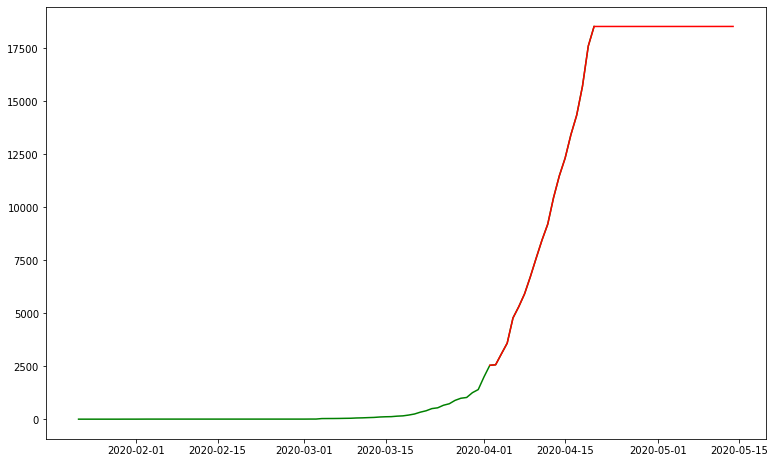

In [45]:
country = "India"

target = "ConfirmedCases"
region_train_df = train_df[(train_df["Country_Region"]==country)]
region_predict_df = predict_df[(predict_df["Country_Region"]==country)]

fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_axes([0, 0, 1, 1])
ax1.plot(region_train_df["Date"],
         region_train_df[target],
         color="green")

ax1.plot(region_predict_df["Date"],
         region_predict_df[target],
         color="red")
plt.show()

## Delete prediction endpoint

In [42]:
endpoint.delete()

[I 200508 06:38:24 tasks:130] Deleting the endpoint. 
[I 200508 06:38:24 serving:124] Deleted service: anonymous/fairing-service-4bwpn
[I 200508 06:38:24 serving:136] Deleted deployment: anonymous/fairing-deployer-vhrzl
